# TinyRL: A Python Interface for RLtools
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rl-tools/documentation/blob/master/docs/09-TinyRL.ipynb)

For ease of use we provide a Python wrapper for RLtools that can simply be installed by `pip install tinyrl`. It uses `pybind11` which is its only necessary dependency. Since one of the main premises of RLtools is that the size of all data structures and loops is known at compile-time, we can not compile the RLtools interface ahead of time. This issue arises for example with the observation and action dimensionality, which are dependent on the environment and, by the nature of Python, are only known at run-time. Hence we TinyRL compiles the RLtools interface just-in-time, when an RL algorithm is instantiated for a concrete environment.

TinyRL also supports accelerated backends (e.g. Apple Accelerate and Intel MKL). Apple Accelerate is detected automatically and does not require additional actions, while Intel MKL can be installed using the `tinyrl[mkl]` option as can be seen in the following:

In [1]:
!pip install tinyrl[mkl] gymnasium > /dev/null # ignoring the output to keep this notebook concise

TinyRL is compatible with Gym/Gymnasium environments that have continuous actions. In the following we show the training of the pendulum swing-up using SAC as an example:

In [2]:
from tinyrl import SAC
import gymnasium as gym

seed=0x1337
environment_name = "Pendulum-v1"

### Training
Since the RL algorithms in RLtools might create multiple instances of the environment (e.g. for vectorized simulation) we create a factory method that creates an instance of the desired environment and hand it over to the `SAC` function that has been imported from tinyrl. The `SAC` function compiles the RLtools interface and takes a [plethora of options](https://github.com/rl-tools/tinyrl/blob/fdc2b19e896543a437fd859fb7eceed2550b975a/tinyrl/src/sac.py#L14). It returns the compiled module which contains a wrapper for [the SAC training loop state data structure](https://github.com/rl-tools/rl-tools/blob/master/include/rl_tools/rl/algorithms/sac/loop/core/state.h). Once the training state is instantiated, the training can be progressed step-by-step like described in [The Loop Interface](./07-The%20Loop%20Interface.ipynb).

In [3]:
def env_factory():
    env = gym.make(environment_name)
    env.reset(seed=seed)
    return env
sac = SAC(env_factory)
state = sac.State(seed)
finished = False
while not finished:
    finished = state.step()

MKL is installed. Version: 2024.1.0 (include: 2024.1.0)
MKL include path: /opt/conda/lib/python3.12/site-packages/../../../include
New SAC config detected, forcing recompilation...
Compiling the TinyRL interface...
Finished compiling the TinyRL interface.
Step: 0/10000 Mean return: -1312.71
Step: 1000/10000 Mean return: -1594.03
Step: 2000/10000 Mean return: -1271.26
Step: 3000/10000 Mean return: -958.029
Step: 4000/10000 Mean return: -1021.33
Step: 5000/10000 Mean return: -875.209
Step: 6000/10000 Mean return: -875.252
Step: 7000/10000 Mean return: -907.503
Step: 8000/10000 Mean return: -666.743
Step: 9000/10000 Mean return: -339.823
Time: 3.746s


### Inference
To show the behavior of the policy we install some utilities for rendering:

In [4]:
!pip install gymnasium[classic-control] imageio > /dev/null

Now we can instantiate an environment as usual:

In [5]:
import imageio, io
from IPython.display import Image, display

env = gym.make('Pendulum-v1', render_mode='rgb_array')
env.reset(seed=seed) and None

You can evaluate the policy using `action = state.action(observation)` (also during the training to, e.g., assess the performance at different stages). In the following, we execute the rollout of one episode and generate an animation (you can execute the cell again to sample a new roll-out):

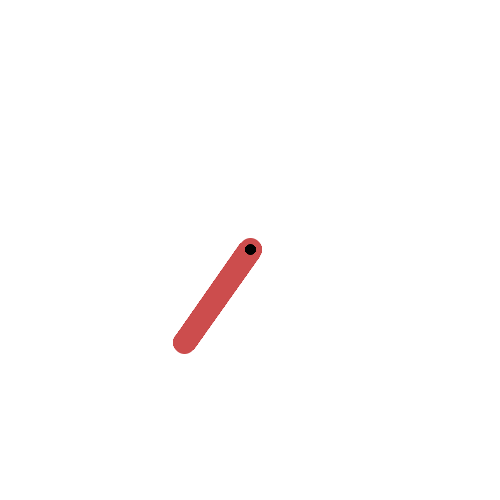

In [6]:
frames = []
observation, _ = env.reset()
finished = False
while not finished:
  frames.append(env.render())
  action = state.action(observation)
  observation, reward, terminated, truncated, _ = env.step(action)
  finished = terminated or truncated
gif_io = io.BytesIO()
imageio.mimsave(gif_io, frames, format="GIF", fps=1/env.env.env.env.dt, loop=0)
gif_io.seek(0)
display(Image(data=gif_io.read(), format='png'))